In [33]:
from datetime import datetime
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
BASE_DATA_PATH = os.path.join("out_cache")
OUTPUT_FOLDER = os.path.join("plots_knn")
TIMES_IN_MS = False

def get_dataset_file(cloud_name, timestamp="latest", data_path=BASE_DATA_PATH):
    csv_folder = os.path.join(data_path, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    df = None

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")

    if timestamp == "latest":
        latest_file = None
        latest_time = None

        for file in csv_files:
            try:
                filename = os.path.basename(file)
                ts_str = '-'.join(filename.split('-')[1:]).replace('.csv', '')
                ts = datetime.strptime(ts_str, "%Y-%m-%d-%H:%M:%S")
                if latest_time is None or ts > latest_time:
                    latest_time = ts
                    latest_file = file
            except Exception as e:
                print(f"Skipping file with invalid timestamp format: {filename} ({e})")
                continue

        if latest_file:
            print(f"Loading latest file: {latest_file}")
            df = pd.read_csv(latest_file)
        else:
            raise FileNotFoundError(f"No valid timestamped files found in: {csv_folder}")

    else:
        for file in csv_files:
            try:
                filename = os.path.basename(file)
                ts_str = '-'.join(filename.split('-')[1:]).replace('.csv', '')
                if timestamp == ts_str:
                    print(f"Loading file: {file}")
                    df = pd.read_csv(file)
                    break
            except Exception as e:
                print(f"Skipping file with invalid format: {filename} ({e})")
                continue

        if df is None:
            raise FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")

    # Convert times to milliseconds
    if TIMES_IN_MS:
        for col in ['mean', 'stdev', 'warmup_time']:
            if col in df.columns:
                df[col] = df[col] * 1000

    return df


def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename):
    fig.savefig(os.path.join(OUTPUT_FOLDER, filename + ".pdf"), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [34]:
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    #'axes.titlesize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,  
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, 
    #'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


In [35]:
def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = (0.9, 0.97)):
    legend = fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=pos,
        ncol=len(legend_handles),
        columnspacing=0.8,     # Reduce horizontal space between columns
        handletextpad=0.4,     # Reduce space between handle and text
        borderpad=0.5,         # Padding inside the legend box
        labelspacing=0.3,       # Reduce vertical space between labels
    )
def add_octree_types_legend_right(legend_handles, legend_labels, legend_title, fig, pos=(0.9, 0.9)):
    legend = fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="center left",          # place legend to the right, centered vertically
        bbox_to_anchor=pos,         # just outside the plot on the right
        ncol=1,                     # one column = one line per entry
        columnspacing=0.8,
        handletextpad=0.4,
        borderpad=0.5,
        labelspacing=0.8,           # a bit more vertical spacing for readability
        frameon=False               # optional: remove box around legend for cleaner look
    )

In [36]:
NEIGHBORS_PTR = "neighborsPtr"
NEIGHBORS = "neighbors"
NEIGHBORS_PRUNE = "neighborsPrune"
NEIGHBORS_STRUCT = "neighborsStruct"
NEIGHBORS_APPROX_LOWER = "neighborsApproxLower"
NEIGHBORS_APPROX_UPPER = "neighborsApproxUpper"
MORTON_ENCODER = "MortonEncoder3D"
HILBERT_ENCODER = "HilbertEncoder3D"
NO_ENCODER = "NoEncoding"
LINEAR_OCTREE = "LinearOctree"
POINTER_OCTREE = "Octree"
UNIBN_OCTREE = "unibnOctree"
PCL_KDTREE = "PCLKdTree"
PCL_OCTREE = "PCLOctree"
NEIGHBORS_PCLKD = "neighborsPCLKD"
NEIGHBORS_UNIBN = "neighborsUnibn"
NEIGHBORS_PCLOCT = "PCLOctree"

In [37]:
# This dicts store information about the type parameters and possible combinations used in each visualization, 
# along with the palette of colors
TYPES_INFO_OCTREE_ENCODER = {
    "type_parameters":  ['octree', 'encoder'],
    "available_types": pd.DataFrame({
        'octree': [LINEAR_OCTREE, LINEAR_OCTREE, POINTER_OCTREE, POINTER_OCTREE, POINTER_OCTREE],
        'encoder': [HILBERT_ENCODER, MORTON_ENCODER, HILBERT_ENCODER, MORTON_ENCODER, NO_ENCODER]
    }),

    "palette": {
        (LINEAR_OCTREE, HILBERT_ENCODER): '#1984c5',
        (LINEAR_OCTREE, MORTON_ENCODER): '#63bff0',
        (POINTER_OCTREE, HILBERT_ENCODER): '#c23728',
        (POINTER_OCTREE, MORTON_ENCODER): '#de6e56',
        (POINTER_OCTREE, NO_ENCODER): '#e1a692'
    },
    "display_name" : {
        (LINEAR_OCTREE, HILBERT_ENCODER): r'\text{loct\_hilb}',
        (LINEAR_OCTREE, MORTON_ENCODER): r'\textit{loct\_mort}',
        (POINTER_OCTREE, HILBERT_ENCODER): r'\texttt{poct\_hilb}',
        (POINTER_OCTREE, MORTON_ENCODER): r'\texttt{poct\_mort}',
        (POINTER_OCTREE, NO_ENCODER): r'\texttt{poct\_unsorted}'
    }
}

TYPES_INFO_OP_ENCODER = {
    "type_parameters":  ['operation', 'encoder'],
    "available_types": pd.DataFrame({
        'operation': [NEIGHBORS_STRUCT, NEIGHBORS_STRUCT, 
                      NEIGHBORS_PRUNE, NEIGHBORS_PRUNE, 
                      NEIGHBORS, NEIGHBORS, 
                      NEIGHBORS_PTR, NEIGHBORS_PTR, NEIGHBORS_PTR],
        'encoder': [HILBERT_ENCODER, MORTON_ENCODER, 
                    HILBERT_ENCODER, MORTON_ENCODER, 
                    HILBERT_ENCODER, MORTON_ENCODER, 
                    HILBERT_ENCODER, MORTON_ENCODER, NO_ENCODER]
    }),

    "palette": {
        (NEIGHBORS_STRUCT, HILBERT_ENCODER): "#7a2495",
        (NEIGHBORS_STRUCT, MORTON_ENCODER): "#b351d1",
        (NEIGHBORS_PRUNE, HILBERT_ENCODER): "#0e8263",
        (NEIGHBORS_PRUNE, MORTON_ENCODER): '#22a884',
        (NEIGHBORS, HILBERT_ENCODER): '#1984c5',
        (NEIGHBORS, MORTON_ENCODER): '#63bff0',
        (NEIGHBORS_PTR, HILBERT_ENCODER): '#c23728',
        (NEIGHBORS_PTR, MORTON_ENCODER): '#de6e56',
        (NEIGHBORS_PTR, NO_ENCODER): '#e1a692'
    },
    "display_name" : {
        (NEIGHBORS_STRUCT, HILBERT_ENCODER): r'\textit{neighborsStruct} + Hilb',
        (NEIGHBORS_STRUCT, MORTON_ENCODER): r'\textit{neighborsStruct} + Mort',
        (NEIGHBORS_PRUNE, HILBERT_ENCODER): r'\textit{neighborsPrune} + Hilb',
        (NEIGHBORS_PRUNE, MORTON_ENCODER): r'\textit{neighborsPrune} + Mort',
        (NEIGHBORS, HILBERT_ENCODER): r'\textit{neighbors} + Hilb',
        (NEIGHBORS, MORTON_ENCODER): r'\textit{neighbors} + Mort',
        (NEIGHBORS_PTR, HILBERT_ENCODER): r'\textit{neigborsPtr} + Hilb',
        (NEIGHBORS_PTR, MORTON_ENCODER): r'\textit{neigborsPtr} + Mort',
        (NEIGHBORS_PTR, NO_ENCODER): r'\textit{neigborsPtr} '
    }
}

palette_ops = sns.color_palette("viridis", n_colors=4)
palette_structs = sns.dark_palette(palette_ops[3], n_colors=8, input="rgb")
sns.hls_palette()
TYPES_INFO_OPERATIONS = {
    "type_parameters":  ['octree', 'operation'],
    "available_types": pd.DataFrame({
        'octree': [POINTER_OCTREE, LINEAR_OCTREE, LINEAR_OCTREE, LINEAR_OCTREE],
        'operation': [NEIGHBORS_PTR, NEIGHBORS, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT]
    }),

    "palette": {
        (POINTER_OCTREE, NEIGHBORS_PTR): palette_ops[0],
        (LINEAR_OCTREE, NEIGHBORS): palette_ops[1],
        (LINEAR_OCTREE, NEIGHBORS_PRUNE): palette_ops[2],
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): palette_ops[3],
    },
    "display_name" : {
        (POINTER_OCTREE, NEIGHBORS_PTR): r'\textit{neighborsPtr}',
        (LINEAR_OCTREE, NEIGHBORS): r'\textit{neighbors}',
        (LINEAR_OCTREE, NEIGHBORS_PRUNE): r'\textit{neighborsPrune}',
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): r'\textit{neighborsStruct}',
    }
}

TYPES_INFO_STRUCTURES = {
    "type_parameters":  ['octree', 'operation'],
    "available_types": pd.DataFrame({
        'octree': [LINEAR_OCTREE, UNIBN_OCTREE, PCL_OCTREE, PCL_KDTREE],
        'operation': [NEIGHBORS_STRUCT, NEIGHBORS_UNIBN, NEIGHBORS_PCLOCT, NEIGHBORS_PCLKD]
    }),
    "markertype": {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): 'o',   # circle
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): 'x',     # x marker
        (PCL_OCTREE, NEIGHBORS_PCLOCT): '*',       # star
        (PCL_KDTREE, NEIGHBORS_PCLKD): '^',       # triangle up
    },
    "palette": {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): palette_structs[7],
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): palette_structs[5],
        (PCL_OCTREE, NEIGHBORS_PCLOCT): palette_structs[3],
        (PCL_KDTREE, NEIGHBORS_PCLKD): palette_structs[1],
    },
    "display_name" : {
        (LINEAR_OCTREE, NEIGHBORS_STRUCT): r'\textit{neighborsStruct}',
        (UNIBN_OCTREE, NEIGHBORS_UNIBN): r'\textit{unibnOctree}',
        (PCL_OCTREE, NEIGHBORS_PCLOCT): r'\textit{PCL Octree}',
        (PCL_KDTREE, NEIGHBORS_PCLKD): r'\textit{PCL KD-tree}'
    }
}

In [38]:
from matplotlib.colors import rgb2hex
hex_colors = [rgb2hex(color) for color in palette_ops]
print(hex_colors)

['#414487', '#2a788e', '#22a884', '#7ad151']


In [39]:
DATA_SUBSET = os.path.join(BASE_DATA_PATH, "subset")
DATA_FULL = os.path.join(BASE_DATA_PATH, "full")
DATA_PARALLEL_SUBSET = os.path.join(BASE_DATA_PATH, "parallel_subset")
DATA_PARALLEL_FULL = os.path.join(BASE_DATA_PATH, "parallel_full")
DATA_APPROX_SUBSET = os.path.join(BASE_DATA_PATH, "approx_subset")
DATA_APPROX_FULL = os.path.join(BASE_DATA_PATH, "approx_full")

In [40]:
# Multiple datasets
CLOUDS_DATASETS = {
                    "Lille_0": "Paris_Lille", 
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5080_54400": "DALES"
                }
RADII = {0.5, 1.0, 2.0, 3.0}
CLOUDS_DATASETS_HIGH_DENSITY = {
                    "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "Speulderbos_2017_TLS": "Speulderbos"
                }
RADII_HIGH_DENSITY = {0.01, 0.05, 0.1}
ALL_CLOUDS = CLOUDS_DATASETS.copy()
ALL_CLOUDS.update(CLOUDS_DATASETS_HIGH_DENSITY)

In [41]:
def octree_runtime_comparison(cloud, data_path, operations , legend_title = r"Combinación \textit{Octree} y SFC", 
                                show_warmup_time=False, types_info=TYPES_INFO_OCTREE_ENCODER, cols = 1, figsz = (7,10), legend_pos=(0.9, 1.0), encoder = "all", kernels="all", show_legend = True):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter the dataset for the specified operation
    df = df[df['operation'].isin(operations)]
    # Get unique radii and kernels
    radii = sorted(df['radius'].unique())
    if kernels != "all":
        if isinstance(kernels, str):
            kernels = [kernels]
        df = df[df["kernel"].isin(kernels)]
    
    kernels = df['kernel'].unique()
    if encoder != "all":
        df = df[df["encoder"] == encoder]

    print(df)
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(int(np.ceil(len(radii)/cols)), cols, figsize=figsz,
                              gridspec_kw={'hspace': 0.3}, squeeze = False)

    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(types_info["available_types"])
    group_gap = 0.2
    legend_handles, legend_labels = [], []
    curr_row, curr_col = 0, 0
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[curr_row][curr_col]
        radius_data = df[df['radius'] == radius]
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'Kernel {kernel}\nSin datos')
                continue
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f"$\\mathcal{{N}}_{{{kernel}}}$\n$\\mu = {avg_total:.0f}$")
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = kernel_data[
                    (kernel_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]
                if octree_data.empty:
                    continue
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                warmup_times = octree_data['warmup_time'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Main execution time bar
                bar = ax.bar(x_pos, means[0], bar_width,
                             color=types_info["palette"][key])
                
                # Warmup time bar (if enabled)
                if show_warmup_time:
                    ax.bar(x_pos, warmup_times[0], bar_width, 
                           color="none", 
                           edgecolor='black', alpha = 0.5,
                           zorder=-2)  # Ensure it's drawn on top
                
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                formatted_label = types_info["display_name"][key]
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        alignment_x = 0 if curr_col == 0 else 0.85
        ax.text(alignment_x, 1.1, f'$r = {radius}~m$',
                transform=ax.transAxes,
                fontsize=16,
                va='top', ha='left')
       
        ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}")
        ax.tick_params(axis="x", which="both", length=0)
        curr_col += 1
        if curr_col == cols:
            curr_col = 0
            curr_row+=1
    if show_legend:
        add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = legend_pos)
    return fig

In [42]:
import scipy.stats as stats
def plot_cache_fails_improvement(clouds_datasets, kernel, operations, data_path, types_info=TYPES_INFO_OCTREE_ENCODER, encoder = "all", 
                              legend_pos = (0.905, 0.98), show_legend = True, legend_title = r"Combinación \textit{Octree} y SFC", fsz=(8,7)):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=fsz)
    legend_handles, legend_labels = [], []
    
    for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
        key = tuple(params[col] for col in types_info["type_parameters"])
        avg_sizes, runtimes = [], []
        for df_name, df in dfs.items():
            if kernel == "all":
                df = df[(df['operation'].isin(operations))]
            else:
                df = df[(df['kernel'] == kernel) & (df['operation'].isin(operations))]
            if encoder != "all":
                df = df[df["encoder"] == encoder]
            if df.empty:
                continue
            octree_data = df[
                (df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            print(octree_data)
            if octree_data.empty:
                continue
            avg_sizes.extend(octree_data['avg_result_size'].tolist())
            runtimes.extend(octree_data['mean'].tolist())

        if avg_sizes and runtimes:
            scatter_kwargs = {'s': 20}
            if "palette" in types_info:
                scatter_kwargs['color'] = types_info["palette"][key]
            if "markertype" in types_info:
                scatter_kwargs['s'] = 35
                print(key)
                scatter_kwargs['marker'] = types_info["markertype"][key]

            scatter = ax.scatter(avg_sizes, runtimes, **scatter_kwargs)
            legend_handles.append(scatter)
            legend_labels.append(types_info["display_name"][key])
            # linear regression line
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(avg_sizes), np.log(runtimes))
            regression_line = np.exp(intercept + slope * np.log(np.array(avg_sizes)))
            ax.plot(avg_sizes, regression_line, color=types_info["palette"][key], linestyle='dashed', linewidth=1)
    
    total_morton_runtimes = []
    total_hilbert_runtimes = []
    for df_name, df in dfs.items():
        if df.empty:
            continue
        morton_df = df[(df["encoder"] == MORTON_ENCODER)]
        hilbert_df = df[(df["encoder"] == HILBERT_ENCODER)]
        total_morton_runtimes.extend(morton_df["mean"].tolist())
        total_hilbert_runtimes.extend(hilbert_df["mean"].tolist())
    # Compute average reduction across all matched pairs
    avg_morton_runtime = np.mean(total_morton_runtimes)
    avg_hilbert_runtime = np.mean(total_hilbert_runtimes)

    print(f"Average Morton runtime:  {avg_morton_runtime:.4f}")
    print(f"Average Hilbert runtime: {avg_hilbert_runtime:.4f}")


    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(r"$\mu$", fontsize=16)
    ax.set_ylabel(f"Tiempo total {'(ms)' if TIMES_IN_MS else '(s)'}", fontsize=16)
        
    # Add legend and titles
    if show_legend:
        add_octree_types_legend(legend_handles, legend_labels, legend_title, fig, pos = legend_pos)
    return fig

In [43]:
L1_MISSES = "l1d_miss"
L2_MISSES = "l2d_miss"
L3_MISSES = "l3_miss"

In [44]:
def combine_and_compute_improvements(dfs, context_cols=["kernel", "radius"]):
    if isinstance(dfs, pd.DataFrame):
        dfs = {"default_dataset": dfs}
    # Concatenate all datasets into one DataFrame, add a 'dataset' column for tracking
    combined_df = []
    for name, df in dfs.items():
        df = df.copy()
        df['dataset'] = name
        combined_df.append(df)
    combined_df = pd.concat(combined_df, ignore_index=True)
    
    # Filter and keep only relevant columns
    combined_df = combined_df[['dataset', 'octree', 'operation', 'encoder', 'radius', 'kernel',
                               'num_searches', 'avg_result_size', L1_MISSES, L2_MISSES, L3_MISSES]]
    combined_df = combined_df[combined_df["kernel"] != "KNN"]
    
    # Create multi-index for easy baseline lookup
    idx_cols = ['dataset'] + context_cols + ['operation', 'octree', 'encoder']
    combined_df_indexed = combined_df.set_index(idx_cols)
    
    # Initialize improvement columns with NaNs
    for level in [L1_MISSES, L2_MISSES, L3_MISSES]:
        combined_df[f"{level}_improv"] = np.nan
    
    # Iterate over rows and compute improvements relative to baseline
    for idx, row in combined_df.iterrows():
        # Baseline: octree=Octree, encoder=NoEncoding, operation=neighborsPtr for the same dataset and context
        if row["octree"] == "Octree" and row["encoder"] == "NoEncoding":
            continue
        
        baseline_key = (row['dataset'], row['kernel'], row['radius'], "neighborsPtr", "Octree", "NoEncoding")
        
        try:
            baseline_row = combined_df_indexed.loc[baseline_key]
        except KeyError:
            # Baseline missing, skip
            continue
        
        for level in [L1_MISSES, L2_MISSES, L3_MISSES]:
            baseline_val = baseline_row[level]
            current_val = row[level]
            if baseline_val != 0 and not pd.isna(baseline_val) and not pd.isna(current_val):
                improve_col = f"{level}_improv"
                combined_df.at[idx, improve_col] = (baseline_val - current_val) / baseline_val * 100
    
    return combined_df


In [45]:
def plot_cache_miss_improv(df, df_name, cache_type=L1_MISSES, percents=True, ops = [NEIGHBORS, NEIGHBORS_PTR],):

    fig, ax = plt.subplots(figsize=(10,5))
    fig.subplots_adjust(right=0.75)
    legend_handles, legend_labels = [], []
    improv_col = cache_type + ("_improv" if percents else "")
    
    all_y_values = []  # collect all y-values plotted for axis limits

    for j, (_, params) in enumerate(TYPES_INFO_OP_ENCODER["available_types"].iterrows()):
        key = tuple(params[col] for col in TYPES_INFO_OP_ENCODER["type_parameters"])
        if key[1] == "NoEncoding" and percents:
            continue
        
        # Filter data by operation and key
        data = df[
            (df['operation'].isin(ops)) &
            (df[TYPES_INFO_OP_ENCODER["type_parameters"]] == pd.Series(key, index=TYPES_INFO_OP_ENCODER["type_parameters"])).all(axis=1)
        ]
        data = data[["avg_result_size", improv_col]]    
        if data.empty:
            continue
        
        grouped = data.groupby("avg_result_size")[improv_col].mean().reset_index()
        line, = ax.plot(grouped["avg_result_size"], grouped[improv_col], marker='o',
                        color=TYPES_INFO_OP_ENCODER["palette"][key],
                        label=rf"${TYPES_INFO_OP_ENCODER['display_name'][key]}$")
        
        all_y_values.extend(grouped[improv_col].values)
        
        if TYPES_INFO_OP_ENCODER["display_name"][key] not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(TYPES_INFO_OP_ENCODER["display_name"][key])
    if percents:
        ax.set_title(r"Mejora en " + cache_type + " respecto a  \\textit{neighborsPtr} sin SFC")
    else:
        ax.set_title(r"Número de fallos caché " + cache_type)

    add_octree_types_legend_right(legend_handles, legend_labels, "Algoritmo + SFC", fig,
    
    pos=(0.75,0.5))
    ax.set_xlabel(r"$\mu$", fontsize=18)
    ax.set_ylabel(
        r"Fallos caché (reducción en \%)" if percents else "Fallos caché",
        fontsize=16
    )
    ax.set_xscale("log")
    
    # Set y-limits
    if all_y_values:
        ymin = min(min(all_y_values), 0)
        ymax = max(all_y_values)
        ax.set_ylim(ymin, ymax + 15)


Loading latest file: out_cache/subset/Lille_0/Lille_0-2025-07-09-14:34:58.csv
Loading latest file: out_cache/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-07-09-14:47:22.csv
Loading latest file: out_cache/subset/5080_54400/5080_54400-2025-07-09-14:43:59.csv
Loading latest file: out_cache/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-07-09-15:07:14.csv
Loading latest file: out_cache/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-09-15:15:39.csv
Loading latest file: out_cache/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-07-09-17:45:44.csv


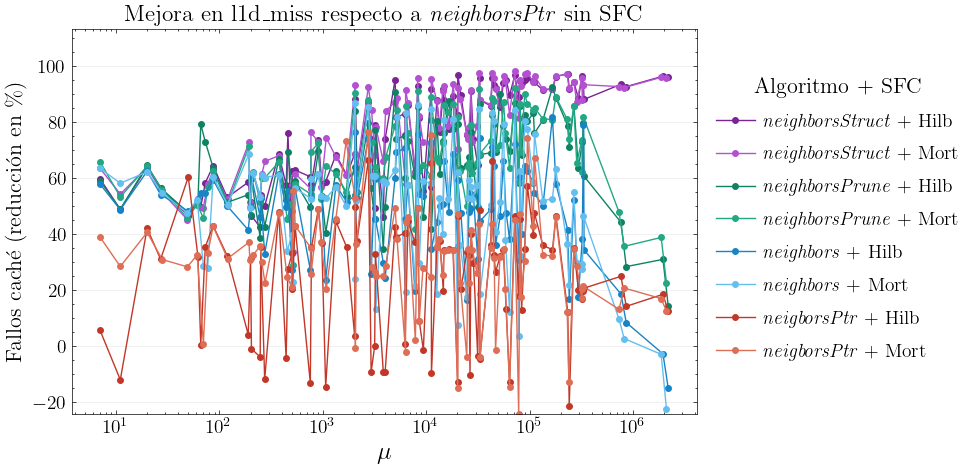

In [46]:
dfs = read_multiple_datasets(ALL_CLOUDS, DATA_SUBSET)
df = combine_and_compute_improvements(dfs)
plot_cache_miss_improv(df, "all datasets", L1_MISSES, True, ops= [NEIGHBORS_PTR, NEIGHBORS, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT])

Loading latest file: out_cache/subset/Lille_0/Lille_0-2025-07-09-14:34:58.csv


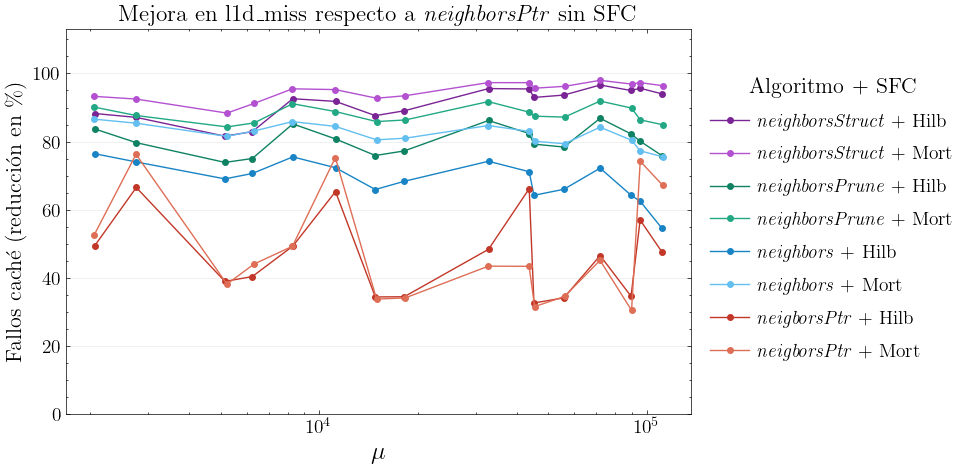

In [47]:
df = get_dataset_file("Lille_0", data_path=DATA_SUBSET)
df = combine_and_compute_improvements(df)
plot_cache_miss_improv(df, "Lille_0", L1_MISSES, True, ops=[NEIGHBORS, NEIGHBORS_PTR, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT])

Loading latest file: out_cache/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-07-09-17:45:44.csv


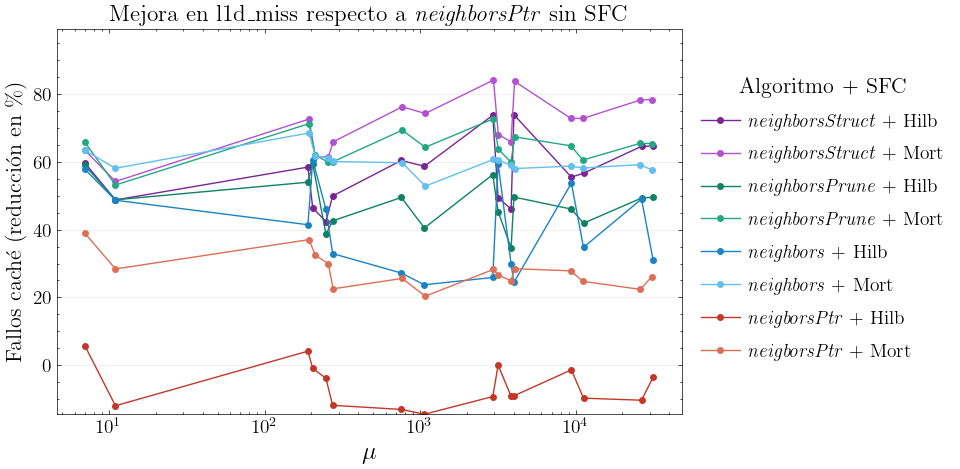

In [48]:
df = get_dataset_file("Speulderbos_2017_TLS", data_path=DATA_SUBSET)
df = combine_and_compute_improvements(df)
plot_cache_miss_improv(df, "Speulderbos_2017_TLS", L1_MISSES, True, ops=[NEIGHBORS, NEIGHBORS_PTR, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT])

Loading latest file: out_cache/subset/5080_54400/5080_54400-2025-07-09-14:43:59.csv


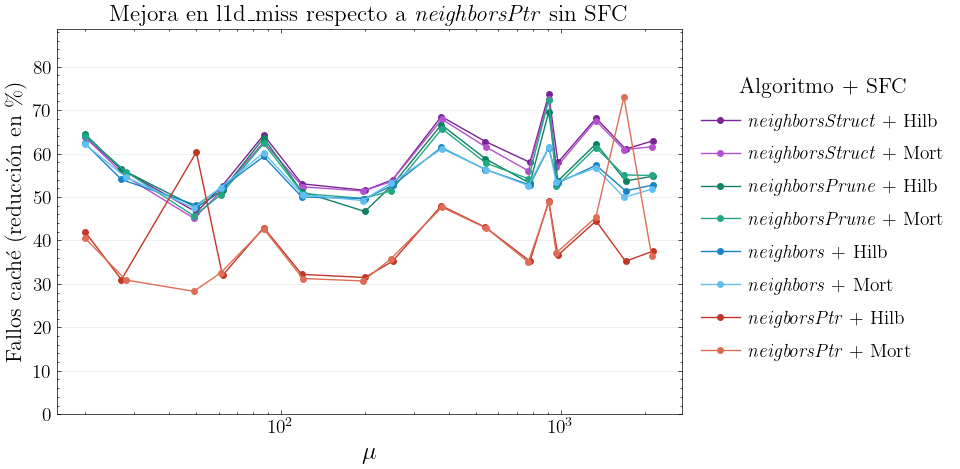

In [49]:
df = get_dataset_file("5080_54400", data_path=DATA_SUBSET)
df = combine_and_compute_improvements(df)
plot_cache_miss_improv(df, "5080_54400", L1_MISSES, True, ops=[NEIGHBORS, NEIGHBORS_PTR, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT])

Loading latest file: out_cache/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-09-15:15:39.csv


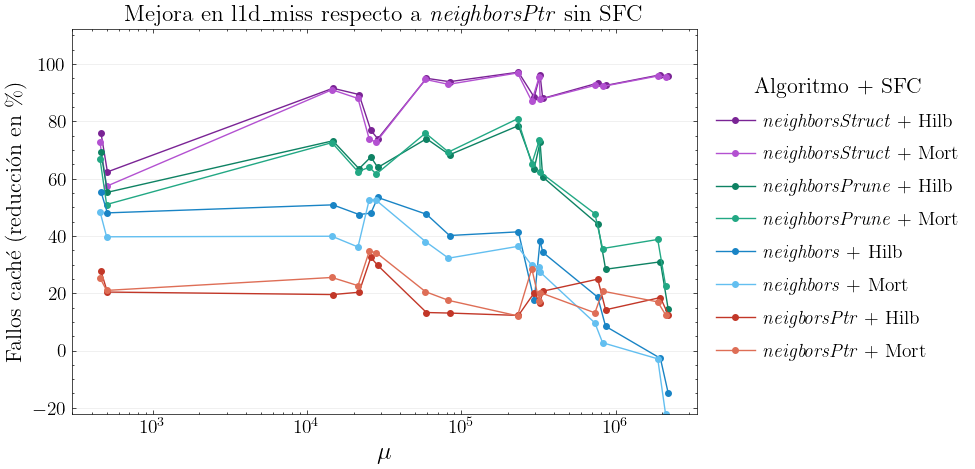

In [50]:
df = get_dataset_file("sg27_station8_intensity_rgb", data_path=DATA_SUBSET)
df = combine_and_compute_improvements(df)
plot_cache_miss_improv(df, "sg27_station8_intensity_rgb", L1_MISSES, True, ops=[NEIGHBORS, NEIGHBORS_PTR, NEIGHBORS_PRUNE, NEIGHBORS_STRUCT])

In [51]:
def plot_knn_results(df, df_name, encoder=MORTON_ENCODER, ops=None):
    df = df[df["kernel"] == "KNN"]
    df = df[["octree", "encoder", "npoints", "operation", "num_searches", 
             "sequential_searches", "mean", "avg_result_size", "l1d_miss", "l2d_miss", "l3_miss"]]
    n_searches = df.iloc[0]["num_searches"]
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.subplots_adjust(right=0.75)  # leave space for external legend

    legend_handles, legend_labels = [], []
    all_y_values = []
    xticks_set = set()

    ops = ops or df["operation"].unique()
    
    for op in ops:
        data = df[df["operation"] == op]
        if data.empty:
            continue

        grouped = data.groupby("avg_result_size")["mean"].mean().reset_index()
        grouped = grouped.sort_values("avg_result_size")
        
        line, = ax.plot(
            grouped["avg_result_size"],
            grouped["mean"],
            marker='o',
            label=op
        )
        all_y_values.extend(grouped["mean"].values)
        xticks_set.update(grouped["avg_result_size"].unique())

        legend_handles.append(line)
        legend_labels.append(r"\textit{" + op + r"}")

    ax.set_title(f"Tiempos para {n_searches} búsquedas KNN en " + df_name, fontsize=16)
    ax.set_xlabel(r"$k$", fontsize=18)
    ax.set_ylabel("Tiempo (s)", fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Set xticks at present avg_result_size values
    xticks = sorted(xticks_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(x)) if x == int(x) else f"{x:.1f}" for x in xticks], rotation=45)

    # Add legend to the right, one row per entry
    fig.legend(
        legend_handles,
        legend_labels,
        title="Algoritmo KNN",
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
        ncol=1,
        columnspacing=0.8,
        handletextpad=0.4,
        borderpad=0.5,
        labelspacing=0.8,
        frameon=False
    )

    plt.tight_layout()
    plt.show()


Loading latest file: out_cache/subset/Lille_0/Lille_0-2025-07-09-14:34:58.csv
Loading latest file: out_cache/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-07-09-14:47:22.csv
Loading latest file: out_cache/subset/5080_54400/5080_54400-2025-07-09-14:43:59.csv
Loading latest file: out_cache/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-07-09-15:07:14.csv
Loading latest file: out_cache/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-09-15:15:39.csv
Loading latest file: out_cache/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-07-09-17:45:44.csv


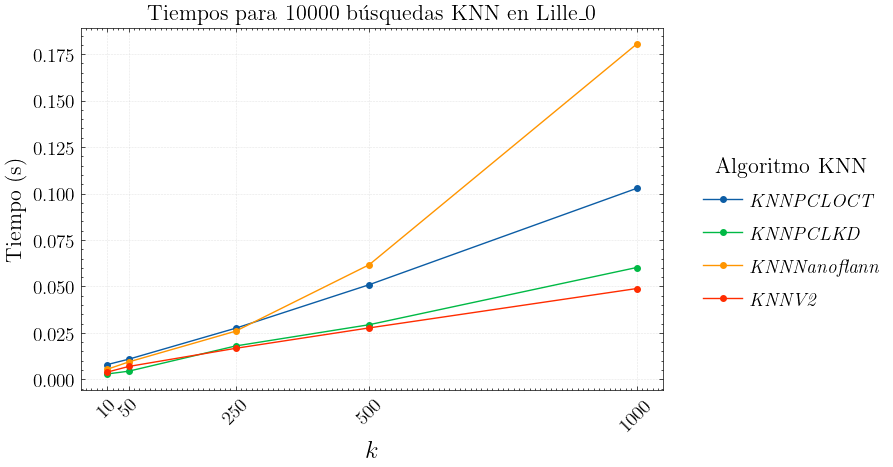

In [52]:
dfs = read_multiple_datasets(ALL_CLOUDS, DATA_SUBSET)
df = dfs["Lille_0"]
plot_knn_results(df, "Lille_0", MORTON_ENCODER)

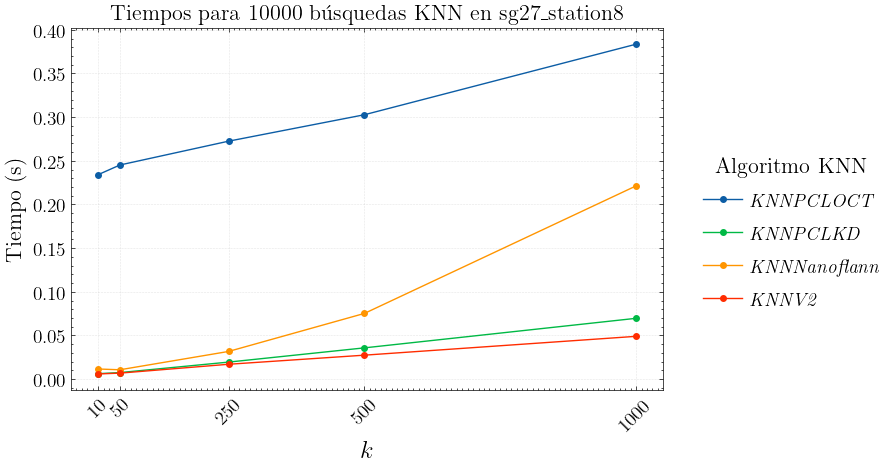

In [53]:
df = dfs["sg27_station8_intensity_rgb"]
plot_knn_results(df, "sg27_station8")

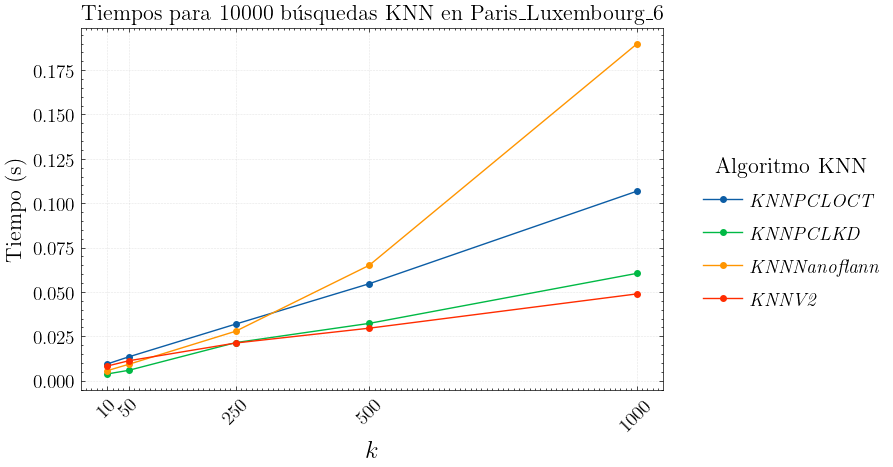

In [54]:
df = dfs["Paris_Luxembourg_6"]
plot_knn_results(df, "Paris_Luxembourg_6")

In [55]:
dfs = read_multiple_datasets(ALL_CLOUDS, DATA_SUBSET)


Loading latest file: out_cache/subset/Lille_0/Lille_0-2025-07-09-14:34:58.csv
Loading latest file: out_cache/subset/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-07-09-14:47:22.csv
Loading latest file: out_cache/subset/5080_54400/5080_54400-2025-07-09-14:43:59.csv
Loading latest file: out_cache/subset/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-07-09-15:07:14.csv
Loading latest file: out_cache/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-09-15:15:39.csv
Loading latest file: out_cache/subset/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-07-09-17:45:44.csv


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [57]:
def plot_knn_results_params(df, df_name, encoder='MORTON_ENCODER', ops=None, xlim=None):
    df = df[df["kernel"] == "KNN"]
    df = df[["octree", "encoder", "npoints", "operation", "num_searches", 
             "sequential_searches", "mean", "avg_result_size", "max_leaf"]]
    n_searches = df.iloc[0]["num_searches"]
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.subplots_adjust(right=0.75)

    legend_handles, legend_labels = [], []
    all_y_values = []
    xticks_set = set()

    ops = ops or df["operation"].unique()
    op_to_cmap = {
        op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")
        for i, op in enumerate(ops)
    }

    for op in ops:
        op_data = df[df["operation"] == op]
        if op_data.empty:
            continue
        min_leaf = op_data["max_leaf"].min() * 1.2
        max_leaf = op_data["max_leaf"].max() * 1.5
        norm = mcolors.Normalize(vmin=min_leaf, vmax=max_leaf)

        for max_leaf in sorted(op_data["max_leaf"].unique()):
            data = op_data[op_data["max_leaf"] == max_leaf]
            if xlim is not None:
                data = data[(data["avg_result_size"] >= xlim[0]) & (data["avg_result_size"] <= xlim[1])]
            if data.empty:
                continue

            grouped = data.groupby("avg_result_size")["mean"].mean().reset_index()
            grouped = grouped.sort_values("avg_result_size")

            color = op_to_cmap[op](1.0 - norm(max_leaf))  # darker for lower max_leaf
            line, = ax.plot(
                grouped["avg_result_size"],
                grouped["mean"],
                marker='o',
                label=f"{op} $N_{{max}}$={max_leaf}",
                color=color
            )

            all_y_values.extend(grouped["mean"].values)
            xticks_set.update(grouped["avg_result_size"].unique())
            legend_handles.append(line)
            legend_labels.append(r"\textit{" + op + r"}" + r"~$N_{max} = " + str(max_leaf) + r"$")

    ax.set_title(f"Tiempos para {n_searches} búsquedas KNN en " + df_name, fontsize=16)
    ax.set_xlabel(r"$k$", fontsize=18)
    ax.set_ylabel("Tiempo (s)", fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)

    fig.legend(
        legend_handles,
        legend_labels,
        title="Algoritmo KNN",
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
        ncol=1,
        columnspacing=0.8,
        handletextpad=0.4,
        borderpad=0.5,
        labelspacing=0.8,
        frameon=False
    )

    return fig

In [58]:
DATA_SUBSET = os.path.join("out_params", "subset")
DATA_FULL = os.path.join("out_params", "full")
PARAMS_CLOUDS = {
                    "Lille_0": "Paris_Lille", 
                    "5080_54400": "DALES",
                    "sg27_station8_intensity_rgb": "Semantic3D"
                }
dfs = read_multiple_datasets(PARAMS_CLOUDS, DATA_SUBSET)


Loading latest file: out_params/subset/Lille_0/Lille_0-2025-07-15-20:26:06.csv
Loading latest file: out_params/subset/5080_54400/5080_54400-2025-07-15-20:26:20.csv
Loading latest file: out_params/subset/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-15-20:26:35.csv


/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


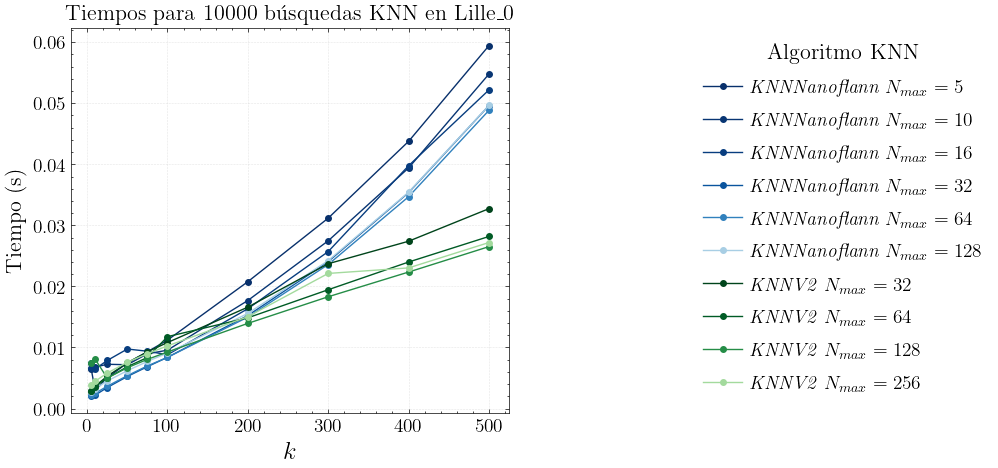

In [59]:
df = dfs["Lille_0"]
fig = plot_knn_results_params(df, "Lille_0", MORTON_ENCODER, xlim=(0,500))
output_fig(fig, "lille_0_knn_random")
fig

/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


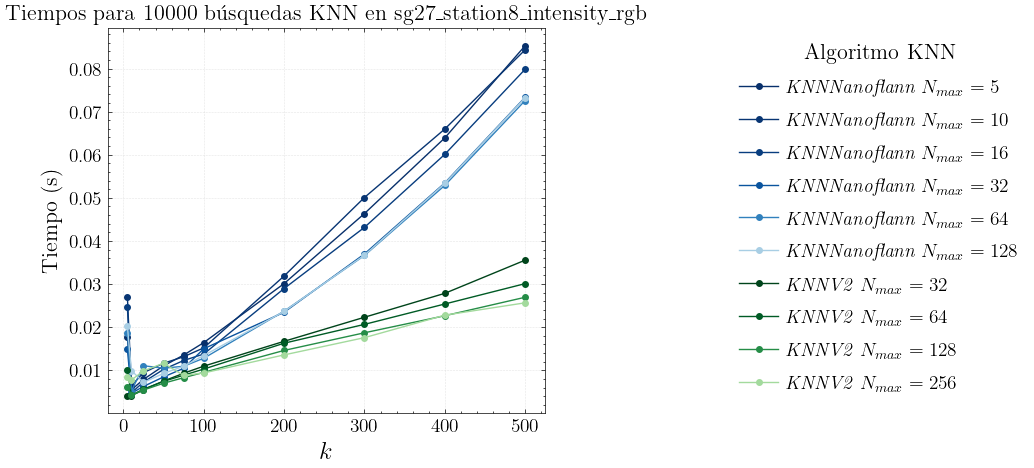

In [60]:
df = dfs["sg27_station8_intensity_rgb"]
fig = plot_knn_results_params(df, "sg27_station8_intensity_rgb", MORTON_ENCODER, xlim=(0,500))
output_fig(fig, "sg27_knn_random")
fig

/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


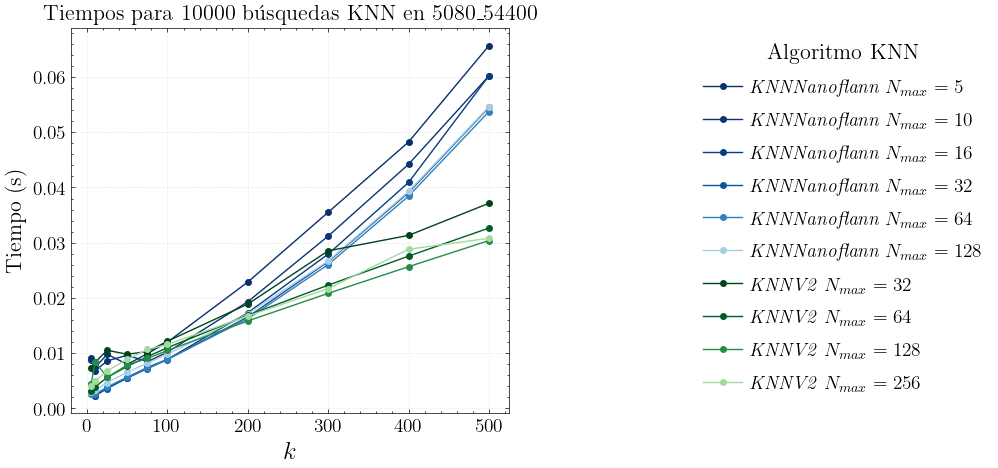

In [61]:
df = dfs["5080_54400"]
fig = plot_knn_results_params(df, "5080_54400", MORTON_ENCODER, xlim=(0,500))
output_fig(fig, "5080_54400_knn_random")
fig

Loading latest file: out_params/full/Lille_0/Lille_0-2025-07-16-11:39:26.csv


/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


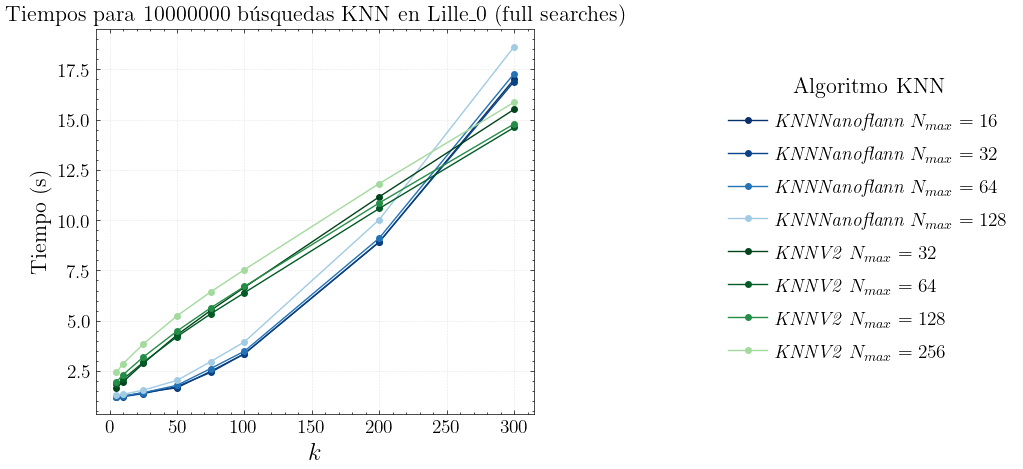

In [62]:
df = get_dataset_file("Lille_0", "latest", DATA_FULL)
fig = plot_knn_results_params(df, "Lille_0 (full searches)", MORTON_ENCODER, xlim=(0,300))
output_fig(fig, "lille_0_knn_full")
fig

Loading latest file: out_params/full/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-07-17-13:23:50.csv


/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


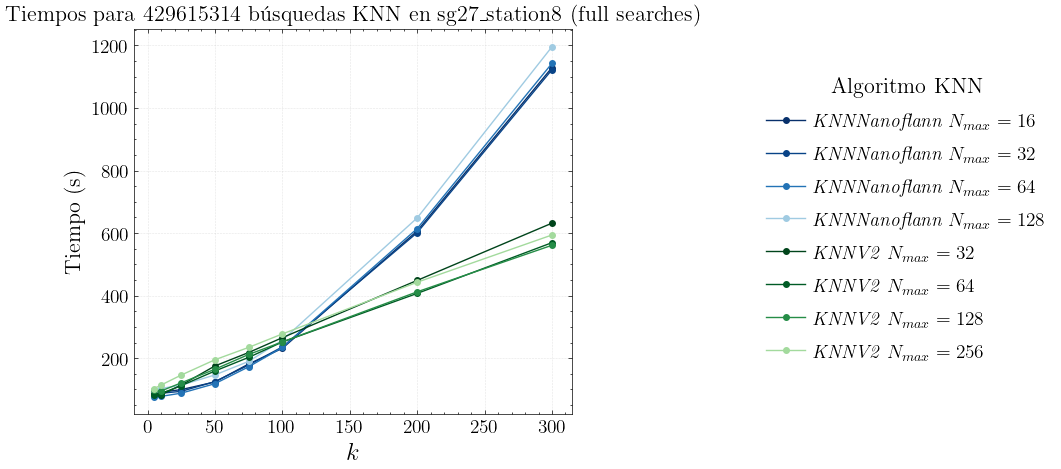

In [63]:
df = get_dataset_file("sg27_station8_intensity_rgb", "latest", DATA_FULL)
fig = plot_knn_results_params(df, "sg27_station8 (full searches)", MORTON_ENCODER, xlim=(0,300))
output_fig(fig, "sg27_knn_full")
fig

Loading latest file: out_params/full/5080_54400/5080_54400-2025-07-17-13:22:53.csv


/tmp/ipykernel_1356/2814890283.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  op: cm.get_cmap("Blues") if i == 0 else cm.get_cmap("Greens")


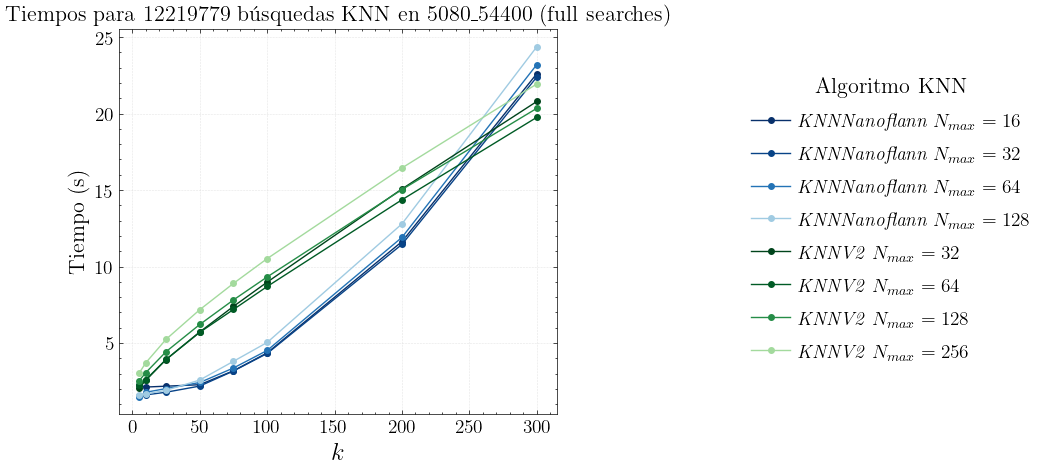

In [64]:
df = get_dataset_file("5080_54400", "latest", DATA_FULL)
fig = plot_knn_results_params(df, "5080_54400 (full searches)", MORTON_ENCODER, xlim=(0,300))
output_fig(fig, "5080_54400_knn_full")
fig